# Video Conferencing Application (Google Meet)

## PySpark setup

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, IntegerType, DoubleType, LongType, ByteType, BooleanType

In [4]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", '4G') \
    .config("spark.ui.killEnabled", False) \
    .getOrCreate()
spark.sparkContext.setLogLevel('OFF')

22/05/27 09:36:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Pyspark Tutorial

In [7]:
df = spark.read.option("inferSchema",True).option("header",True).csv('test.csv')
df.show()

+---+-----+-----+
| id|label|value|
+---+-----+-----+
|  1|  "C"|  3.0|
|  2|  "D"|  2.0|
|  3|  "A"|  5.0|
|  4|  "C"|  2.0|
|  5|  "C"|  9.0|
|  6|  "A"| -1.0|
+---+-----+-----+



### Select

### Filter

### Aggregation

### Sort

Sort descending by value and ascending by id

### Add a new column

new_value = value + 3

### Windowing

Order, partition, Between

### Iterate over rows using .collect()

## Video Conferencing Analysis

In [4]:
df = spark.read.parquet("data/0.parquet").cache()

In [5]:
df.show(n=5)

+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+-------+-------+---------------+-------------------+--------------+-------+----------------+------+----------+------------+-----------+---------------+
|                  ts|          sIP|sPort|          dIP|dPort|ip_len|ip_hdr_len|ip_proto|tcp_flags|tcp_seq|tcp_ack|   tls_hostname|       dns_hostname|        dns_ip|rtp_seq|rtp_payload_type|rtp_ts|rtp_marker|rtp_ext_flag|rtp_ext_len|rtp_padding_len|
+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+-------+-------+---------------+-------------------+--------------+-------+----------------+------+----------+------------+-----------+---------------+
| 1.652830550357248E9|192.168.1.236|37883|  192.168.1.1|   53|    65|        20|      17|     null|   null|   null|           null|               null|          null|   null|            null|  null|      null|        null|       null|           nu

In [6]:
df.count()

23513

## VCA session traffic

In [7]:
df.select('sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'rtp_payload_type').filter(
    df.rtp_payload_type.isNotNull()).distinct().show(truncate=False)

+-------------+-----+-------------+-----+--------+----------------+
|sIP          |sPort|dIP          |dPort|ip_proto|rtp_payload_type|
+-------------+-----+-------------+-----+--------+----------------+
|142.250.82.87|3478 |192.168.1.236|45626|17      |97              |
|142.250.82.87|3478 |192.168.1.236|45626|17      |96              |
+-------------+-----+-------------+-----+--------+----------------+



## Isolating video stream

In [8]:
HOST_IP = "192.168.1.236"
GMEET_IP = "142.250.82.87"
HOST_PORT = 45626
GMEET_PORT = 3478
TRANSPORT_PROTO = 17

In [9]:
flow_df = df.filter((((df.sIP == GMEET_IP) & (df.dIP == HOST_IP) & 
                      (df.sPort == GMEET_PORT) & (df.dPort == HOST_PORT)) | 
                     ((df.sIP == HOST_IP) & (df.dIP == GMEET_IP) & 
                      (df.sPort == HOST_PORT) & (df.dPort == GMEET_PORT))) &
                    (df.ip_proto == TRANSPORT_PROTO)) \
            .sort('ts').select('ts', 'sIP', 'sPort', 'dPort', 'ip_len', 'ip_hdr_len', 'ip_proto', 
                               'rtp_seq', 'rtp_payload_type', 'rtp_ts', 'rtp_marker', 'rtp_ext_flag', 'rtp_ext_len', 
                               'rtp_padding_len')
# flow_df = flow_df.withColumn('ts', flow_df['ts'] - flow_df.agg({'ts': 'min'}).collect()[0]['min(ts)'])
# flow_df = flow_df.withColumn('idx', F.row_number().over(Window().orderBy('ts')))
flow_df = flow_df.cache()

In [10]:
flow_df.show(n=3)

+--------------------+-------------+-----+-----+------+----------+--------+-------+----------------+------+----------+------------+-----------+---------------+
|                  ts|          sIP|sPort|dPort|ip_len|ip_hdr_len|ip_proto|rtp_seq|rtp_payload_type|rtp_ts|rtp_marker|rtp_ext_flag|rtp_ext_len|rtp_padding_len|
+--------------------+-------------+-----+-----+------+----------+--------+-------+----------------+------+----------+------------+-----------+---------------+
|1.6528305772746215E9|192.168.1.236|45626| 3478|   136|        20|      17|   null|            null|  null|      null|        null|       null|           null|
|1.6528305773035374E9|142.250.82.87| 3478|45626|   120|        20|      17|   null|            null|  null|      null|        null|       null|           null|
|1.6528305773067183E9|192.168.1.236|45626| 3478|   185|        20|      17|   null|            null|  null|      null|        null|       null|           null|
+--------------------+-------------+----

In [11]:
video_flow_df = flow_df.filter(flow_df.rtp_payload_type==96)
video_flow_df = video_flow_df.fillna(
    {'rtp_padding_len': 0, 'rtp_ext_flag': False, 'rtp_ext_len': 0})
video_flow_df = video_flow_df.withColumn(
    'rtp_payload_len',
    (video_flow_df.ip_len - video_flow_df.ip_hdr_len - 20 
     - 4 * video_flow_df.rtp_ext_flag.cast(ByteType())
     * (1 + video_flow_df.rtp_ext_len) 
     - video_flow_df.rtp_padding_len))
video_flow_df = video_flow_df.withColumn(
    'is_down', (video_flow_df.sIP == GMEET_IP).cast(BooleanType()))
video_flow_df = video_flow_df.sort('rtp_seq')
rtp_ts_init_val = video_flow_df.agg(
    {'rtp_ts': 'min'}).collect()[0]['min(rtp_ts)']
video_flow_df = video_flow_df.withColumn(
    'rtp_ts', video_flow_df['rtp_ts'] - rtp_ts_init_val)
video_flow_df = video_flow_df.select(
    'rtp_seq', 'is_down', 'rtp_ts', 'rtp_payload_len', 'rtp_marker').cache()

In [12]:
video_flow_df.show(n=10)

+-------+-------+------+---------------+----------+
|rtp_seq|is_down|rtp_ts|rtp_payload_len|rtp_marker|
+-------+-------+------+---------------+----------+
|      0|   true|     0|           1140|     false|
|      1|   true|     0|           1156|     false|
|      2|   true|     0|           1156|     false|
|      3|   true|     0|           1152|      true|
|      4|   true|  3780|            637|     false|
|      5|   true|  3780|            637|      true|
|      6|   true|  7560|           1178|      true|
|      7|   true| 10530|           1110|      true|
|      8|   true| 14310|            836|     false|
|      9|   true| 14310|            848|      true|
+-------+-------+------+---------------+----------+
only showing top 10 rows



## Grouping packets into frames

1. Create a window ordered by rtp_seq
2. Shift "integer type casted" rtp_marker column value by one down
3. Add `frame_no` column
4. Drop rtp_marker column

## Grouping packets into 1-second windows

1. Divide ts by 90K to get the video timestamp value in seconds
2. Cast the timestamp value to Integer to group timestamps into 1 second windows

1. Group rows by windows and perform aggregation over `rtp_payload_len` to get the number of bytes per window
2. Collect the bytes and store them in a Python list

### Plotting

In [21]:
def change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=False, is_y_log=False):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if is_x_log:
        ax.set_xscale('log')
    if is_y_log:
        ax.set_yscale('log')
    if Xmin is not None:
        ax.set_xlim(xmin=Xmin)
    if Xmax is not None:
        ax.set_xlim(xmax=Xmax)
    ax.grid(True)
    return

def get_color_and_linestyle_kwargs(i):
    color_n = ['r', 'b', 'k', 'g', 'm', 'c', 'y']
    linestyles = ['-', '--', ':', '-.']
    return {'color': color_n[i % len(color_n)], 'linestyle': linestyles[i % len(linestyles)]}

def plotCDF(ax, data, labels, xlabel, ylabel, Xmax=None, Xmin=None, log_scale=False,
            set_legend=True, color_n_linestyle_dicts=None):
    raw = {}
    markers = ['o', '*', '^', '1', '4', 's', 'd', '3', 'd', 'o', '*', '^']

    for key in sorted(labels):
        raw[key] = list(data[key])
        if len(raw[key]) == 0:
            continue

        elms, cts = np.unique(raw[key], return_counts=True)
        cdf = np.cumsum(cts)
        cdf = cdf / cdf[-1]
        kwargs_dict = (get_color_and_linestyle_kwargs(key) if color_n_linestyle_dicts is None
                       else color_n_linestyle_dicts[key])
        ax.step(list(elms[:1]) + list(elms), [0] + list(cdf), where='post',
                label=labels[key], **kwargs_dict)

    # pl.legend((p),legnd,'lower right')
    if len(labels) > 1 and set_legend:
        set_legend_to_right(ax)

    change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=log_scale)
    ax.set_ylim(ymax=1.0)
    ax.set_ylim(ymin=0.0)

#### Cumulative Distribution Function (CDF)

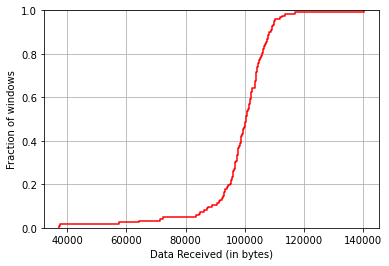

In [22]:
plotCDF(plt.gca(), {0: bytes_data}, {0: ''}, 'Data Received (in bytes)', 'Fraction of windows')
plt.show()

### Line plot

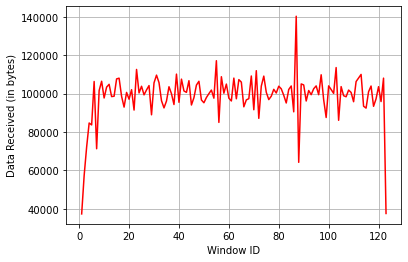

In [23]:
def line_plot():
    window_ids = range(1, 1 + len(bytes_data))
    plt.plot(window_ids, bytes_data, **get_color_and_linestyle_kwargs(0))
    change_plot_params(plt.gca(), 'Window ID', 'Data Received (in bytes)',
                       None, None, is_x_log=False, is_y_log=False)
    return

line_plot()
plt.show()